In [1]:
import PyPDF2
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader
import urllib.parse
import requests
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
import bitermplus as btm
import numpy as np
import tmplot as tmp
import json
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
import pandas as pd
from gensim.models import Word2Vec
from itertools import combinations
import re
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/Users/valeriovalentini/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# WEB SCRAPING

driver = webdriver.Chrome() 

url = 'https://www.mdpi.com/2227-7390/12/1'

driver.get(url)

cookie_button = driver.find_element(By.CLASS_NAME,"CybotCookiebotDialogBodyButton")

time.sleep(6)

cookie_button.click()

html_source = driver.page_source

driver.quit()



In [ ]:
# HTML 

soup = BeautifulSoup(html_source, 'html.parser')

pdf_links = soup.find_all('a', class_='UD_Listings_ArticlePDF')

lista_link_pdf = []

n = 1
lista_link_pdf = []

for link in pdf_links:
    pdf_url = link.get('href')
    full_url = urllib.parse.urljoin('https://www.mdpi.com/', pdf_url)
    lista_link_pdf.append(full_url)
    n += 1
    
    if len(lista_link_pdf) >= 10:
        break


print('\n'.join(lista_link_pdf))


In [ ]:
# PDF DOWNLOAD

n = 1

for full_url in lista_link_pdf:

    pdf_risposta = requests.get(full_url)
        
    if pdf_risposta.status_code == 200:

        pdf_file_name =  f"Articolo_{n}.pdf"
        n += 1
            
        pdf_file = open(pdf_file_name, 'wb')
        pdf_file.write(pdf_risposta.content)
        pdf_file.close()
            
            
        file = open(pdf_file_name, 'rb')
        
        print(pdf_file_name)

        pdf = PdfReader(file)

        num_pagine = len(pdf.pages)

        for i in range(num_pagine):
            contenuto = pdf.pages[i].extract_text()
            #print(contenuto)


        file.close()
                
    else:
        print(f"Errore durante il download del PDF da {pdf_url}")


In [54]:
# PDF TEXT EXTRACTION


testi_articoli = []

for i in range(1, 11):
    with open(f"Articolo_{i}.pdf", 'rb') as articolo:
        pdf_reader = PyPDF2.PdfReader(articolo)

        testo_articolo = ""
        for pagina in range(len(pdf_reader.pages)):
            testo_articolo += pdf_reader.pages[pagina].extract_text()

        testi_articoli.append(testo_articolo)

    
    articolo.close()

print("Esempio di Articolo (Articolo 1):\n")
print('\n'.join(testi_articoli[0].split('\n')[52:80]))


Esempio di Articolo (Articolo 1):

1. Introduction
Ship targets are crucial combat units in modern maritime warfare, and it is important
to recognize them accurately and credibly to enhance maritime situational awareness
and gain an advantage. Infrared (IR) imaging technology is advantageous due to its
all-weather capability, long-range perception, and strong concealment. It, along with
visible light and synthetic aperture radar (SAR) imaging, forms an important means of
acquiring feature information about ship targets and is widely used in ship automatic
target recognition (SATR) tasks [ 1–3]. In the marine environment, different types of ships
exhibit varying degrees of thermal characteristics and IR radiation spectra within the IR
spectrum. This paper focuses on ship IR automatic target recognition (SIATR) technology,
which utilizes sensors to capture IR images of ship targets. By combining image processing,
recognition algorithms, and other techniques, this technology automatically

In [3]:
# TOKENIZZAZIONE

articoli_tokenizzati = []

for testo_articolo in testi_articoli:
    tokens = word_tokenize(testo_articolo)
    articoli_tokenizzati.append(tokens)

print("Esempio di token del primo documento:")
print(articoli_tokenizzati[0][250:260])


Esempio di token del primo documento:
['scenarios', ',', 'there', 'will', 'be', 'various', 'recognition', 'models', 'with', 'different']


In [4]:
# RIMOZIONE STOPWORDS E PUNTEGGIATURA & STEMMATIZZAZIONE

stop_words = set(stopwords.words('english'))

punteggiatura = set(string.punctuation)

lemmatizer = WordNetLemmatizer()

articoli_puliti = []
for articolo in articoli_tokenizzati:
    articolo_pulito = [lemmatizer.lemmatize(word.lower()) for word in articolo if word.isalpha() and word.lower() not in stop_words and word not in punteggiatura]
    articoli_puliti.append(articolo_pulito)

    
    
def mantieni_parole_tra_token_iniziale_e_finali(lista_di_liste, token_iniziale, token_finale1, token_finale2):
    risultato = []
    for lista in lista_di_liste:
        parole_tra_token = []
        trovato_token_iniziale = False
        for parola_lista in lista:
            if trovato_token_iniziale:
                parole_tra_token.append(parola_lista)
                if parola_lista.lower() == token_finale1.lower():
                    indice = lista.index(parola_lista)
                    if indice + 1 < len(lista) and lista[indice + 1].lower() == token_finale2.lower():
                        break
            if parola_lista.lower() == token_iniziale.lower():
                trovato_token_iniziale = True
        risultato.append(parole_tra_token)
    return risultato

articoli_puliti = mantieni_parole_tra_token_iniziale_e_finali(articoli_puliti, "abstract", "author", "contributions")

print("Esempio di token del primo documento dopo rimozione di stopwords e punteggiatura e di lemmatizzazione:")
print(articoli_puliti[1][:10])

Esempio di token del primo documento dopo rimozione di stopwords e punteggiatura e di lemmatizzazione:
['difference', 'scheme', 'approximate', 'dynamic', 'system', 'considered', 'discrete', 'model', 'phenomenon', 'described']


In [5]:
# CREAZIONE DIZIONARIO E CORPUS

dictionary = Dictionary(articoli_puliti)

corpus = [dictionary.doc2bow(doc) for doc in articoli_puliti]

num_topics = 7
#num_topics = int(input("numero di topic:"))

In [58]:
print("Numero totale di token (dopo pre-processing) nel Vocabolario:", len(dictionary))

Numero totale di token (dopo pre-processing) nel Vocabolario: 5675


In [59]:
for i in range(len(articoli_puliti)):
    print(f"Numero di token nell'Articolo {i+1}: {len(articoli_puliti[i])}")

Numero di token nell'Articolo 1: 6509
Numero di token nell'Articolo 2: 3901
Numero di token nell'Articolo 3: 4081
Numero di token nell'Articolo 4: 3887
Numero di token nell'Articolo 5: 5064
Numero di token nell'Articolo 6: 2451
Numero di token nell'Articolo 7: 2516
Numero di token nell'Articolo 8: 7316
Numero di token nell'Articolo 9: 3817
Numero di token nell'Articolo 10: 3078


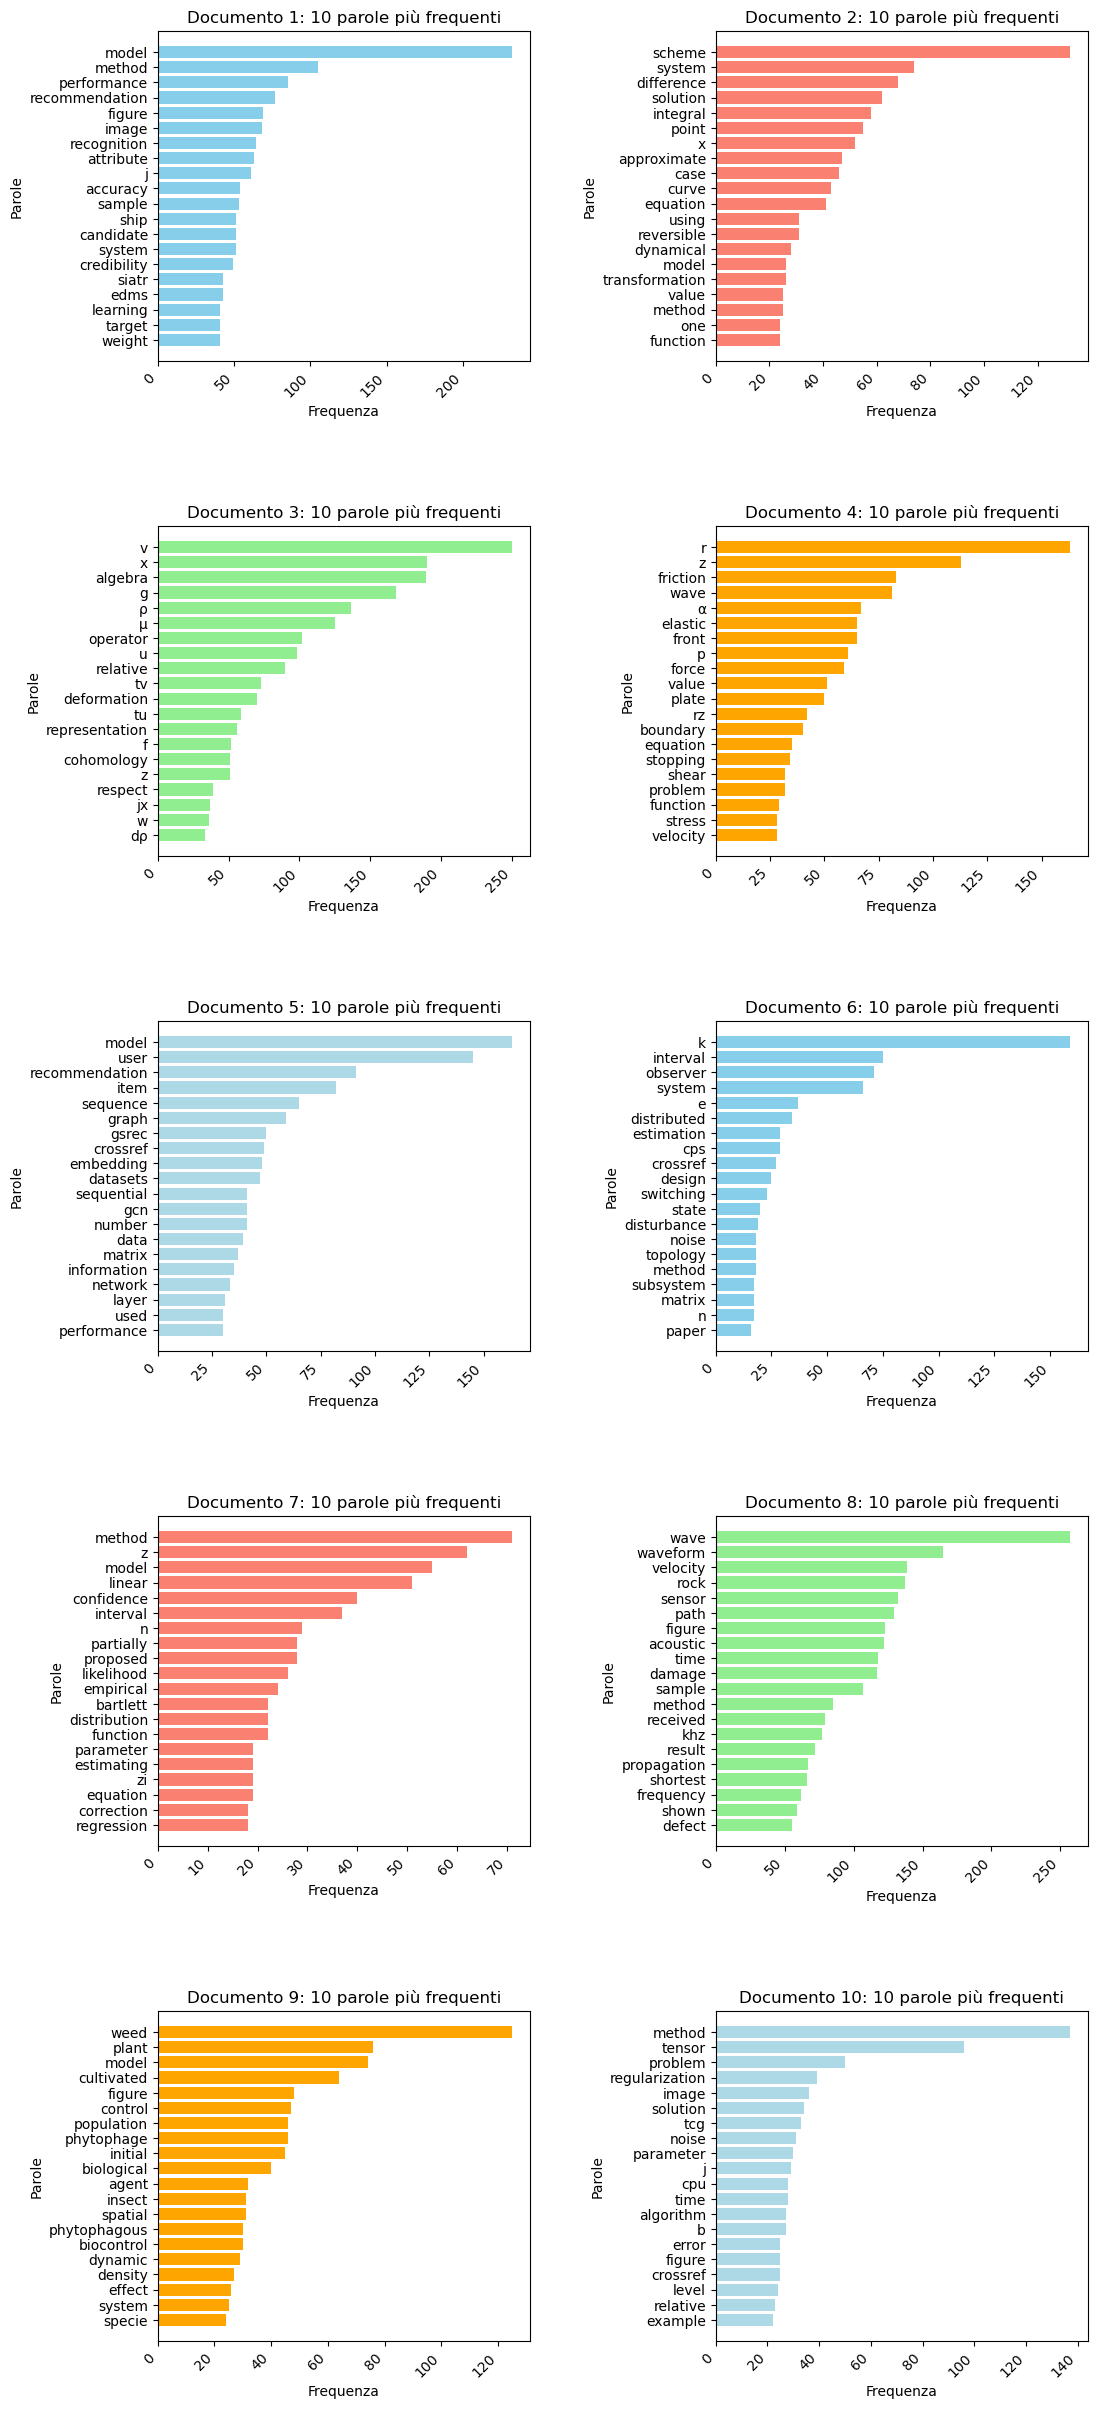

In [10]:
# GRAFICI FREQUENZA
import matplotlib.pyplot as plt
from collections import Counter

colori = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightblue']

larghezza_figura = 12
altezza_figura = 30
num_parole_visualizzate = 20
plt.figure(figsize=(larghezza_figura, altezza_figura))

indice_colore = 0

num_colonne = 2
num_righe = (len(articoli_puliti) + num_colonne - 1) // num_colonne

for idx, doc in enumerate(articoli_puliti, 1):
    
    frequenza_parole = Counter(doc)

    parole_piu_frequenti = frequenza_parole.most_common(num_parole_visualizzate)
    
    # Inverti l'ordine delle parole e delle frequenze
    parole, frequenze = zip(*reversed(parole_piu_frequenti))
    
    colore = colori[indice_colore % len(colori)]
    indice_colore += 1
    
    plt.subplot(num_righe, num_colonne, idx)
    plt.xticks(rotation=45, ha='right')  
    plt.subplots_adjust(hspace=0.5, wspace = 0.5)
    
    plt.barh(parole, frequenze, color=colore)
    plt.xlabel('Frequenza')
    plt.ylabel('Parole')
    plt.title(f'Documento {idx}: 10 parole più frequenti')

plt.show()


In [11]:
# CREAZIONE MODELLO LDA

dictionary = corpora.Dictionary(articoli_puliti)

corpus = [dictionary.doc2bow(articolo) for articolo in articoli_puliti]

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)


In [12]:
# DATAFRAME delle PAROLE e del loro PESO per ogni TOPIC con LDA

topic_dataframes = []

for idx, topic in lda_model.print_topics(num_words=5):
    words = topic.split('+')
    topic_words = []
    weights = []
    for word in words:
        weight, word = word.split('*')
        topic_words.append(word.strip())
        weights.append(float(weight.strip()))
    
    # Creazione del DataFrame per il topic corrente
    topic_df = pd.DataFrame({'Parola': topic_words, 'Peso': weights})
    topic_df.columns = ["Parole", "Peso"]
    
    # Aggiunta del DataFrame alla lista dei DataFrame dei topic
    topic_dataframes.append(topic_df)

# Stampa e visualizzazione dei DataFrame di ciascun topic
for idx, df in enumerate(topic_dataframes, 1):
    print(f"Tabella con le parole principali \ndel Topic {idx} e i loro pesi - LDA")
    display(df)  # Utilizzo di display() invece di print() per mantenere la formattazione di Pandas
    print("\n")  # Aggiunta di una riga vuota tra i DataFrame



Tabella con le parole principali 
del Topic 1 e i loro pesi - LDA


,Parole,Peso
0,"""method""",0.032
1,"""tensor""",0.015
2,"""linear""",0.011
3,"""z""",0.010
4,"""model""",0.009




Tabella con le parole principali 
del Topic 2 e i loro pesi - LDA


,Parole,Peso
0,"""v""",0.051
1,"""x""",0.039
2,"""algebra""",0.039
3,"""g""",0.034
4,"""ρ""",0.028




Tabella con le parole principali 
del Topic 3 e i loro pesi - LDA


,Parole,Peso
0,"""model""",0.025
1,"""k""",0.016
2,"""method""",0.013
3,"""system""",0.012
4,"""performance""",0.009




Tabella con le parole principali 
del Topic 4 e i loro pesi - LDA


,Parole,Peso
0,"""weed""",0.027
1,"""plant""",0.016
2,"""model""",0.016
3,"""cultivated""",0.014
4,"""figure""",0.010




Tabella con le parole principali 
del Topic 5 e i loro pesi - LDA


,Parole,Peso
0,"""model""",0.028
1,"""user""",0.025
2,"""recommendation""",0.015
3,"""item""",0.014
4,"""sequence""",0.011




Tabella con le parole principali 
del Topic 6 e i loro pesi - LDA


,Parole,Peso
0,"""wave""",0.032
1,"""waveform""",0.020
2,"""velocity""",0.017
3,"""rock""",0.017
4,"""sensor""",0.016




Tabella con le parole principali 
del Topic 7 e i loro pesi - LDA


,Parole,Peso
0,"""r""",0.019
1,"""scheme""",0.015
2,"""z""",0.015
3,"""solution""",0.010
4,"""friction""",0.010


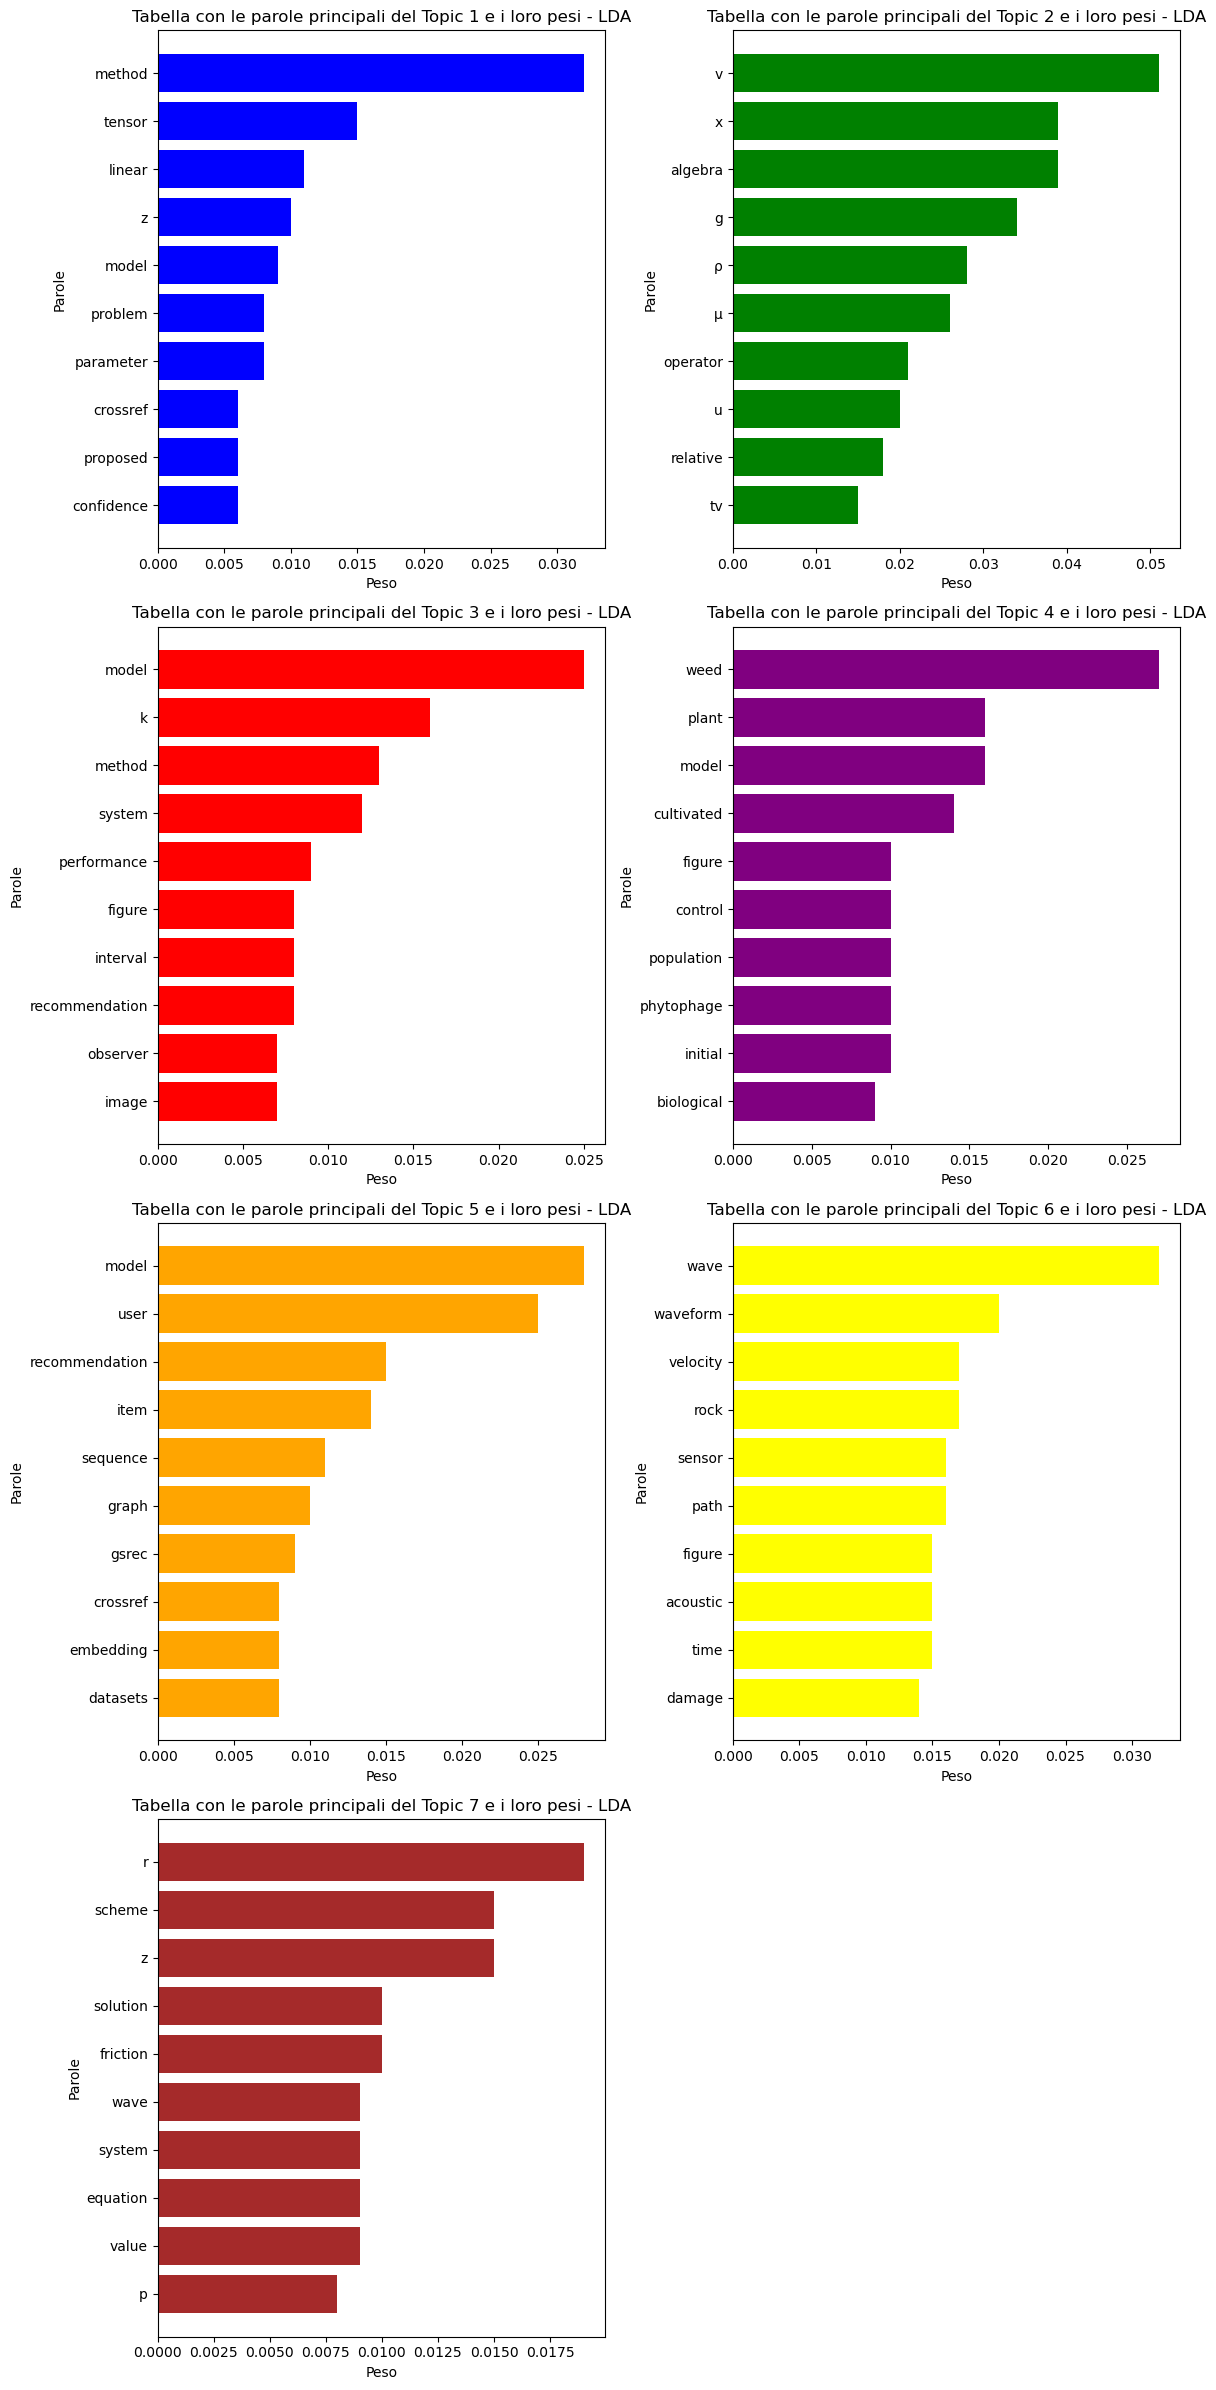

In [22]:
# ISTOGRAMMI delle PAROLE e del loro PESO per ogni TOPIC con LDA

colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink', 'gray', 'cyan']

# Lista dei topic
topics = lda_model.print_topics()

# Estrai le parole e le relative frequenze per ogni topic
topic_words = {}
for idx, topic in enumerate(topics):
    topic_id, word_dist = topic
    word_dist = word_dist.split("+")
    words = [wd.split("*")[1].strip().strip('"') for wd in word_dist]
    freqs = [float(wd.split("*")[0]) for wd in word_dist]
    topic_words[topic_id] = {"parole": words[::-1], "frequenze": freqs[::-1], "colore": colors[idx % len(colors)]}

# Numero di righe e colonne dei subplot
num_rows = len(topic_words) // 2 + len(topic_words) % 2
num_cols = 2

# Disegna gli istogrammi per ogni topic
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

for i, (topic_id, words_freqs) in enumerate(topic_words.items()):
    row = i // num_cols
    col = i % num_cols

    df = pd.DataFrame(words_freqs)
    ax = axes[row, col] if num_rows > 1 else axes[col]

    ax.barh(df["parole"], df["frequenze"], color=words_freqs["colore"])  # Utilizzo di plt.barh
    ax.set_xlabel('Peso')  # Etichetta asse x
    ax.set_ylabel('Parole')  # Etichetta asse y
    ax.set_title(f'Tabella con le parole principali del Topic {topic_id+1} e i loro pesi - LDA')
    ax.tick_params(axis='y', rotation=0)  # Ruota le etichette sull'asse y

# Rimuovi eventuali subplot vuoti
if len(topic_words) % 2 != 0:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()


In [25]:
# MISCELA DI TOPIC PER DOCUMENTO

for i, doc in enumerate(corpus):
    print(f'Documento {i+1}:')
    topics = lda_model.get_document_topics(doc)
    print("Distribuzione dei topic: Topic", (topics[0][0] +1), "con probabilità", round(topics[0][1],4))
    print('\n')



Documento 1:
Distribuzione dei topic: Topic 3 con probabilità 0.9999


Documento 2:
Distribuzione dei topic: Topic 7 con probabilità 0.9998


Documento 3:
Distribuzione dei topic: Topic 2 con probabilità 0.9998


Documento 4:
Distribuzione dei topic: Topic 7 con probabilità 0.9998


Documento 5:
Distribuzione dei topic: Topic 5 con probabilità 0.9998


Documento 6:
Distribuzione dei topic: Topic 3 con probabilità 0.9996


Documento 7:
Distribuzione dei topic: Topic 1 con probabilità 0.9997


Documento 8:
Distribuzione dei topic: Topic 6 con probabilità 0.9999


Documento 9:
Distribuzione dei topic: Topic 4 con probabilità 0.9998


Documento 10:
Distribuzione dei topic: Topic 1 con probabilità 0.9997




In [26]:
import pandas as pd
from gensim.models import CoherenceModel

coherence_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
umass_scores = coherence_umass.get_coherence_per_topic()

# Creazione di un DataFrame per i punteggi di coerenza UMass
df_umass = pd.DataFrame({'Topic': range(1,len(umass_scores)+1), 'Coerenza UMass': umass_scores})
df_umass['Coerenza UMass'] = df_umass['Coerenza UMass'].round(2)

display(df_umass)



,Topic,Coerenza UMass
0,1,-1.70
1,2,-0.83
2,3,-2.13
3,4,-0.51
4,5,-0.43
5,6,-0.55
6,7,-0.84


In [27]:
pyLDAvis.enable_notebook()


lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(lda_display)

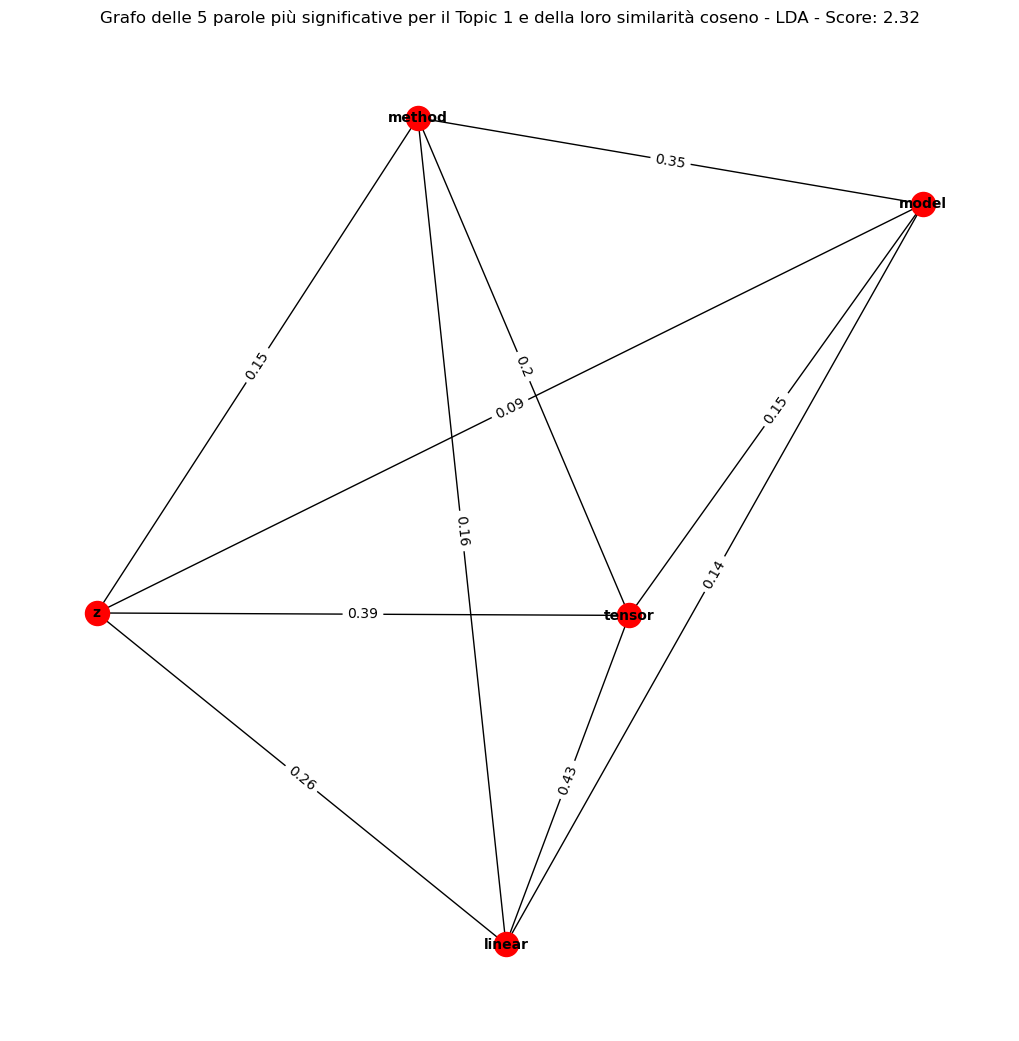

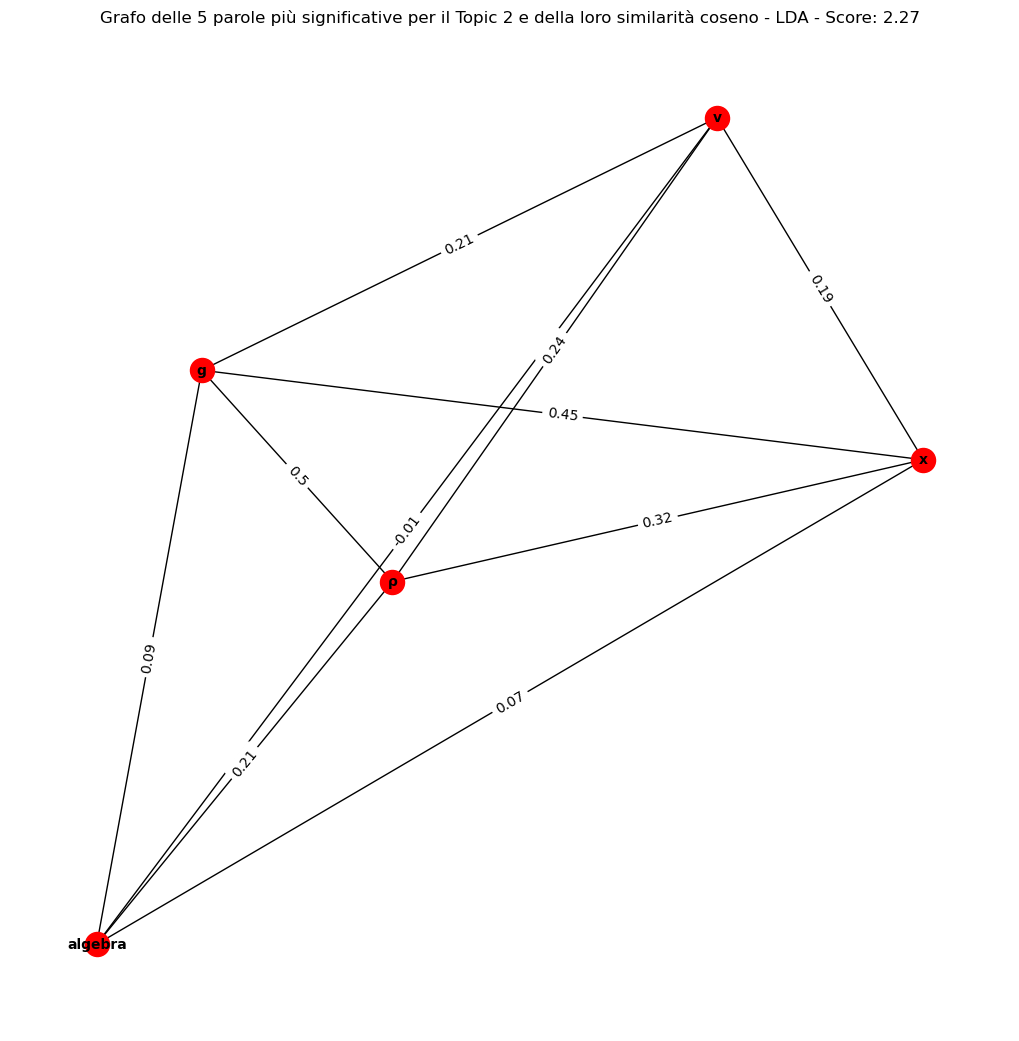

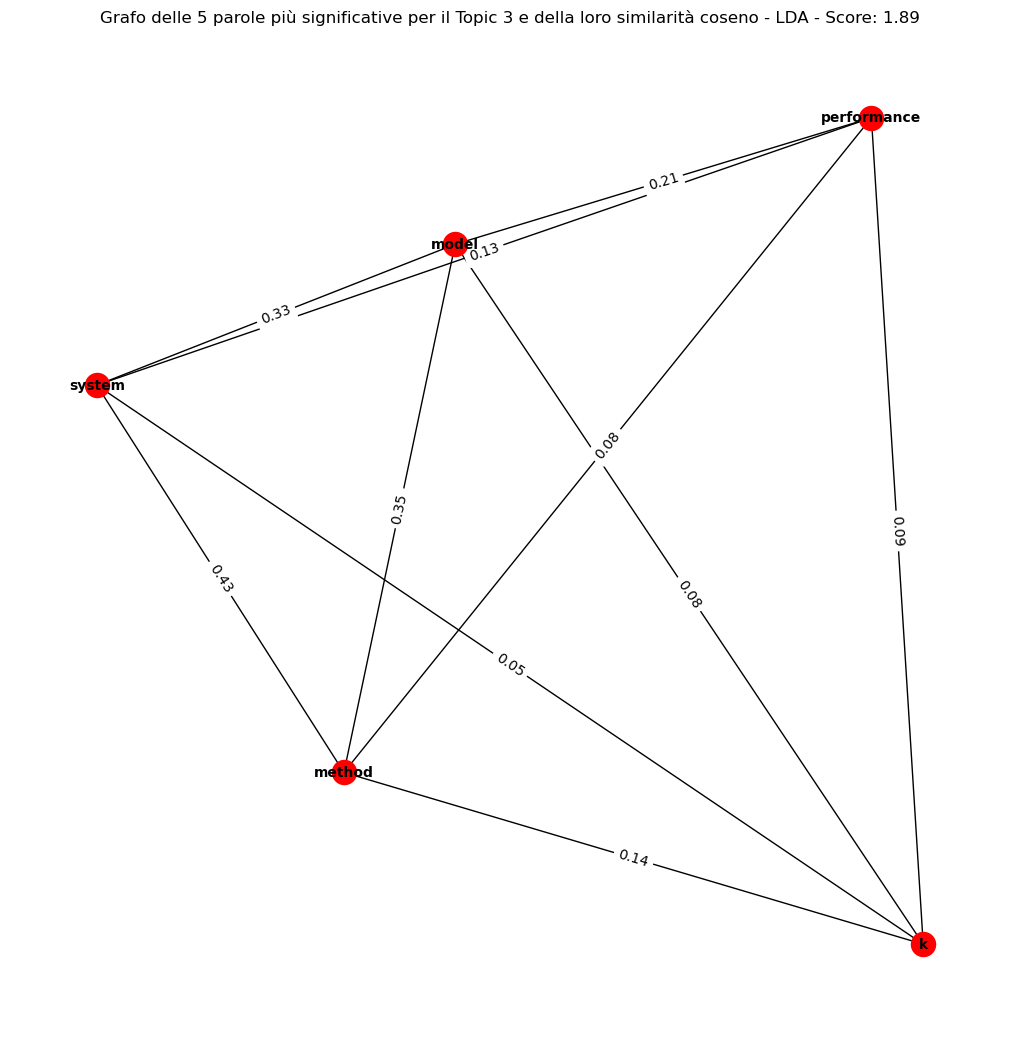

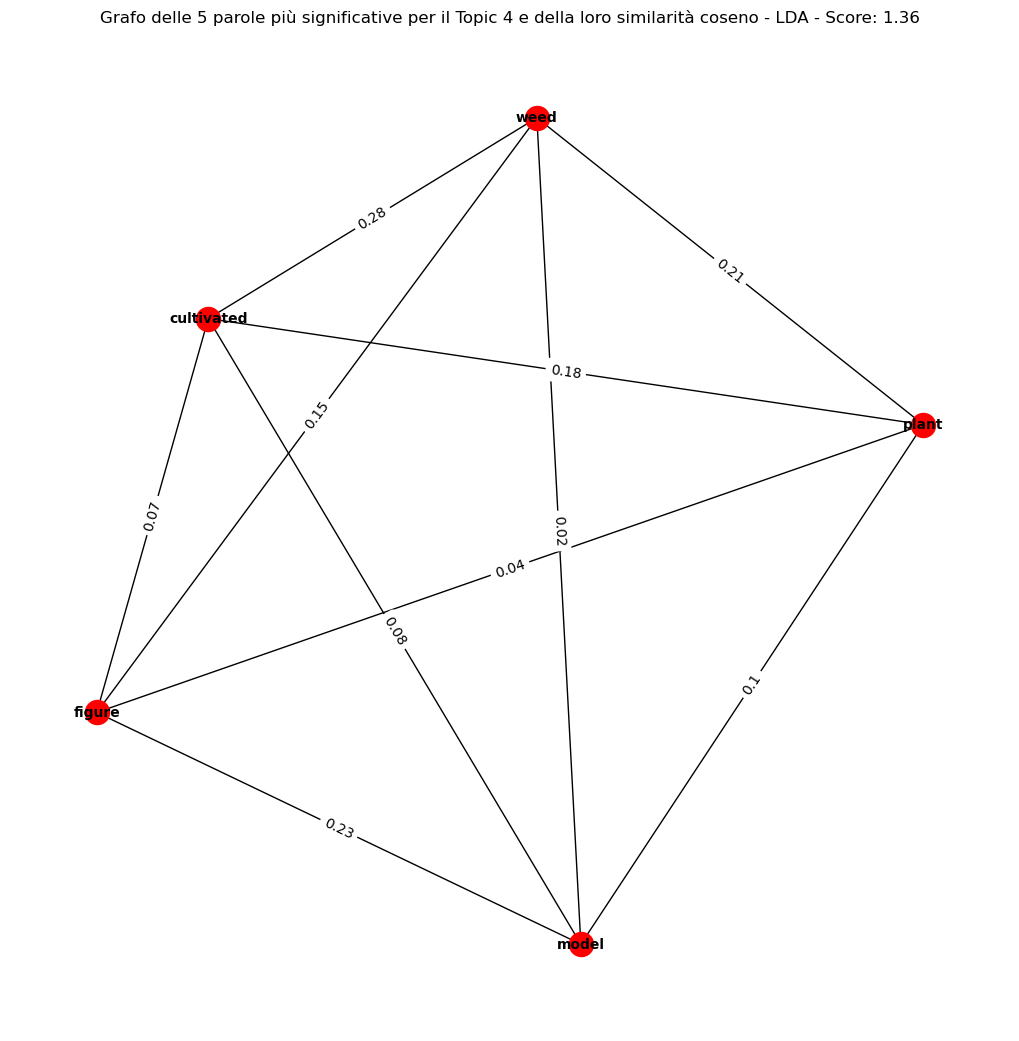

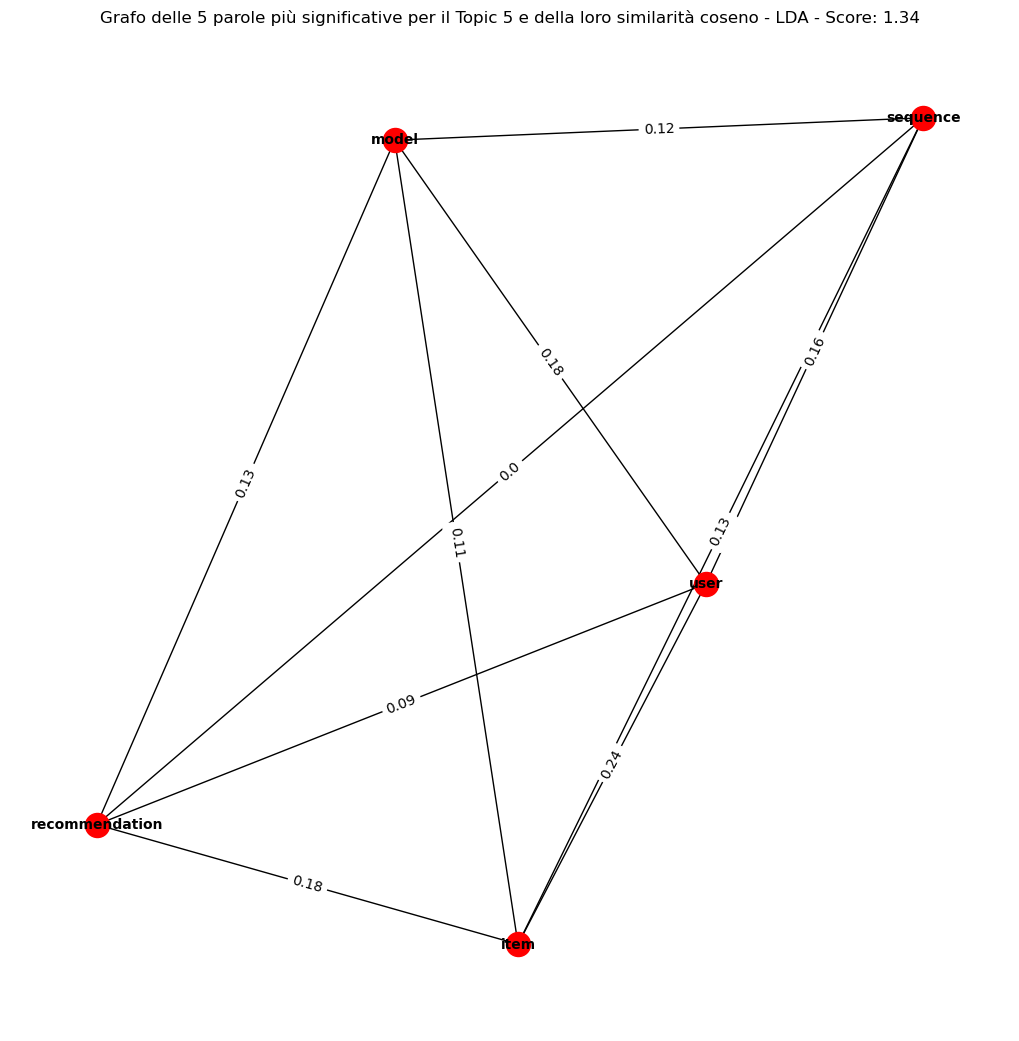

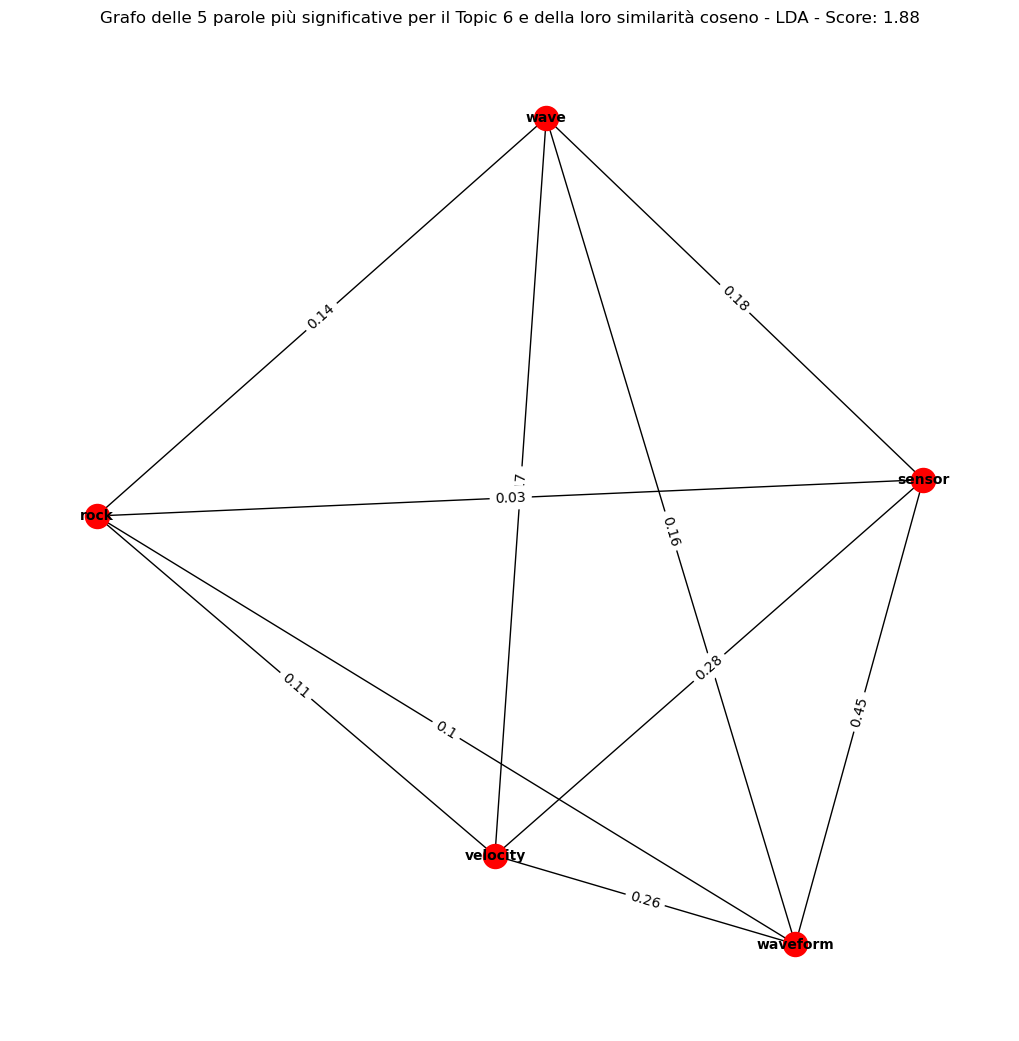

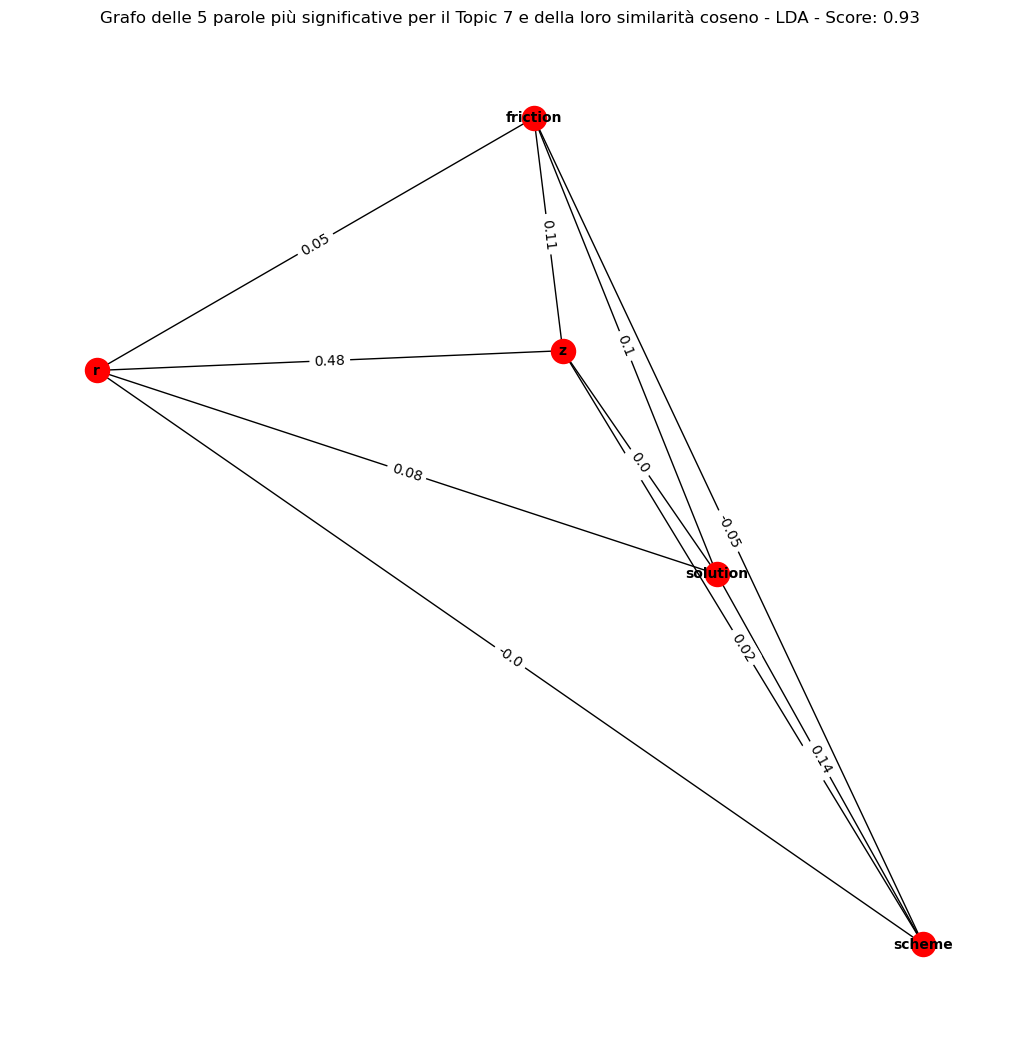

Topic 1: Score = 2.32
Topic 2: Score = 2.27
Topic 3: Score = 1.89
Topic 4: Score = 1.36
Topic 5: Score = 1.34
Topic 6: Score = 1.88
Topic 7: Score = 0.93
 Score Totale: 11.99


In [69]:
topics = lda_model.show_topics(num_topics=num_topics, num_words=5, formatted=False)

word2vec_model = api.load("word2vec-google-news-300")

num_words_per_topic = 10

graph_scores = []

for topic_id, topic_words in topics:
    G_topic = nx.Graph()
    
    for word, _ in topic_words[:num_words_per_topic]:
        G_topic.add_node(word)
    
    for i in range(len(topic_words)):
        for j in range(i+1, len(topic_words)):
            word1 = topic_words[i][0]
            word2 = topic_words[j][0]
            
            try:
                embedding_word1 = word2vec_model[word1]
                embedding_word2 = word2vec_model[word2]
            except KeyError:
                continue
            
            similarity = cosine_similarity([embedding_word1], [embedding_word2])[0][0]
            similarity_rounded = round(similarity, 2)
            
            G_topic.add_edge(word1, word2, weight=similarity_rounded)
    
    graph_score = sum(weight for _, _, weight in G_topic.edges(data='weight'))
    graph_scores.append((topic_id, graph_score))
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G_topic, seed=42)  
    nx.draw(G_topic, pos, with_labels=True, node_size=300, node_color='red', font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(G_topic, 'weight')
    nx.draw_networkx_edge_labels(G_topic, pos, edge_labels=labels)
    plt.title(f"Grafo delle 5 parole più significative per il Topic {topic_id+1} e della loro similarità coseno - LDA - Score: {graph_score:.2f}")
    plt.show()

score_totale = 0
    
for topic_id, score in graph_scores:
    print(f"Topic {topic_id+1}: Score = {score:.2f}")
    score_totale += score
    
print(f" Score Totale: {round(score_totale,2)}")

In [29]:
# CREAZIONE MODELLO BTM 

texts = [' '.join(words) for words in articoli_puliti]

X, vocabulary, vocab_dict = btm.get_words_freqs(texts)

docs_vec = btm.get_vectorized_docs(texts, vocabulary)

biterms = btm.get_biterms(docs_vec)

BTM_model = btm.BTM(X, vocabulary, T=num_topics)
BTM_model.fit(biterms, iterations=50)


100%|██████████| 50/50 [00:01<00:00, 39.94it/s]


In [34]:
# TABELLA DEI TOPIC CON PAROLE in ordine di PESO

print("Tabella con le parole principali per ogni topic in ordine decrescente in base al loro peso in quel topic - BTM \n")
tabella_btm = pd.DataFrame(btm.get_top_topic_words(BTM_model, words_num=20))
tabella_btm = tabella_btm.rename(columns={'topic0': 'Topic 1', 'topic1': 'Topic 2', 'topic2': 'Topic 3', 'topic3': 'Topic 4', 
                                          'topic4': 'Topic 5', 'topic5': 'Topic6', 'topic6': 'Topic 7'})

tabella_btm

Tabella con le parole principali per ogni topic in ordine decrescente in base al loro peso in quel topic - BTM 



,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic6,Topic 7
0,wave,crossref,algebra,model,crossref,model,method
1,waveform,weed,scheme,method,observer,user,tensor
2,figure,model,operator,performance,interval,item,linear
3,velocity,plant,relative,recommendation,system,matrix,model
4,sensor,cultivated,system,system,rock,sequence,problem
5,time,control,solution,figure,method,graph,parameter
6,path,proceeding,equation,accuracy,author,gsrec,proposed
7,acoustic,pp,tv,attribute,data,embedding,interval
8,sample,phytophage,value,sample,distributed,recommendation,error
9,damage,population,deformation,credibility,cps,datasets,solution


In [60]:
# MISCELA DI TOPIC PER DOCUMENTO



doc_topics = BTM_model.transform(docs_vec)

topic_dict = {}

# Creazione di un dizionario dei risultati
for i, array_documento in enumerate(doc_topics):
    documento = {}
    for j, peso in enumerate(array_documento):
        documento[f"Topic {j+1}"] = round(peso,3)
    topic_dict[f"Documento {i+1}"] = documento

# Creazione e visualizzazione dei DataFrame per ogni documento
for documento, topic_weights in topic_dict.items():
    print(f"Tabella con la miscela dei topic per il  {documento} - BTM")
    print("\n")
    df = pd.DataFrame([topic_weights])
    df.index = [documento]
    display(df)
    print("\n")



100%|██████████| 10/10 [00:00<00:00, 454.17it/s]

Tabella con la miscela dei topic per il  Documento 1 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 1,0.029,0.12,0.025,0.593,0.048,0.146,0.039




Tabella con la miscela dei topic per il  Documento 2 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 2,0.018,0.089,0.752,0.023,0.041,0.03,0.047




Tabella con la miscela dei topic per il  Documento 3 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 3,0.004,0.027,0.843,0.011,0.031,0.056,0.028




Tabella con la miscela dei topic per il  Documento 4 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 4,0.136,0.024,0.664,0.02,0.049,0.072,0.035




Tabella con la miscela dei topic per il  Documento 5 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 5,0.015,0.197,0.019,0.129,0.031,0.577,0.032




Tabella con la miscela dei topic per il  Documento 6 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 6,0.022,0.045,0.057,0.038,0.592,0.136,0.11




Tabella con la miscela dei topic per il  Documento 7 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 7,0.02,0.041,0.062,0.041,0.057,0.036,0.744




Tabella con la miscela dei topic per il  Documento 8 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 8,0.733,0.044,0.024,0.039,0.113,0.014,0.032




Tabella con la miscela dei topic per il  Documento 9 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 9,0.032,0.782,0.063,0.041,0.027,0.023,0.033




Tabella con la miscela dei topic per il  Documento 10 - BTM




,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Documento 10,0.032,0.034,0.053,0.056,0.06,0.032,0.734


100%|██████████| 10/10 [00:00<00:00, 348.57it/s]


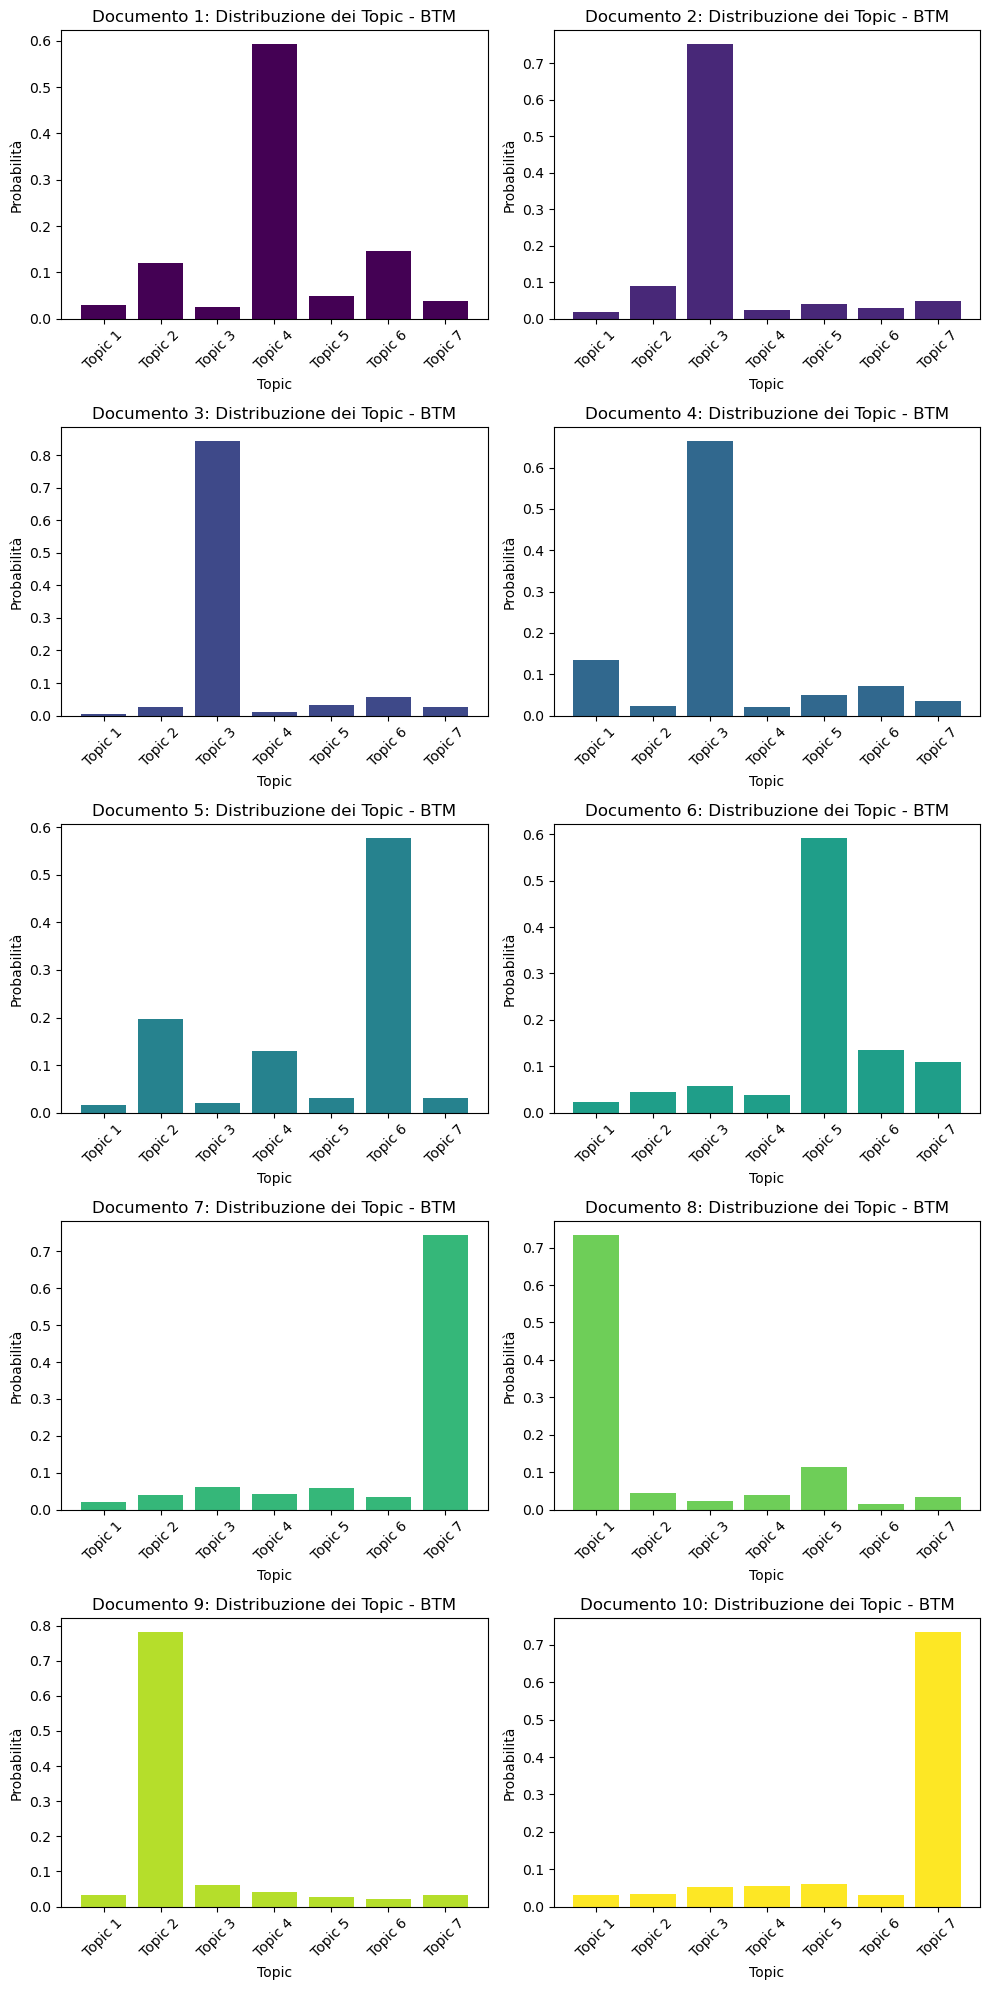

In [38]:
# MISCELA DI TOPIC PER DOCUMENTO - BTM

topic_distributions = BTM_model.transform(docs_vec)

# Numero di righe e colonne per il layout dei subplot
num_rows = len(topic_distributions) // 2 + len(topic_distributions) % 2
num_cols = 2

# Creazione dei subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Flatten degli assi se abbiamo solo un documento
if len(topic_distributions) == 1:
    axes = [axes]

# Colori per i documenti
colors = plt.cm.viridis(np.linspace(0, 1, len(topic_distributions)))

# Creazione degli istogrammi per ogni documento
for i, (doc_dist, ax) in enumerate(zip(topic_distributions, axes.flatten())):
    ax.bar(range(len(doc_dist)), doc_dist, color=colors[i])
    ax.set_xlabel('Topic')
    ax.set_ylabel('Probabilità')
    ax.set_title(f'Documento {i+1}: Distribuzione dei Topic - BTM')
    ax.set_xticks(range(len(doc_dist)))
    ax.set_xticklabels([f'Topic {i+1}' for i in range(len(doc_dist))], rotation=45)  
    

# Rimuovi gli assi vuoti se necessario
if len(topic_distributions) % 2 == 1:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [63]:
coherence = btm.coherence(BTM_model.matrix_topics_words_, X, M=20)

for i in range(len(coherence)):
    if coherence[i] > 0:
        coherence[i] *= -1  # Moltiplica ogni valore di coerenza per -1 per ottenere valori negativi
    print(f"Metodo BTM - Coerenza del Topic {i+1} secondo il metodo UMass: {round(coherence[i], 2)}")


Metodo BTM - Coerenza del Topic 1 secondo il metodo UMass: -2.54
Metodo BTM - Coerenza del Topic 2 secondo il metodo UMass: -14.39
Metodo BTM - Coerenza del Topic 3 secondo il metodo UMass: -38.81
Metodo BTM - Coerenza del Topic 4 secondo il metodo UMass: -34.42
Metodo BTM - Coerenza del Topic 5 secondo il metodo UMass: -24.63
Metodo BTM - Coerenza del Topic 6 secondo il metodo UMass: -3.41
Metodo BTM - Coerenza del Topic 7 secondo il metodo UMass: -67.53


In [85]:
p_zd = BTM_model.transform(docs_vec)



perplexity = btm.perplexity(BTM_model.matrix_topics_words_, p_zd, X, 8)
coherence = btm.coherence(BTM_model.matrix_topics_words_, X, M=20)


print(perplexity)
print(coherence)

100%|██████████| 10/10 [00:00<00:00, 346.26it/s]

792.7568909117917
[ 36.06173258  10.0470435  -41.28791217  -7.39704054 -71.92549495
 -77.59410724 -42.70266048]


In [41]:
tmp.report(model=BTM_model, docs=texts)

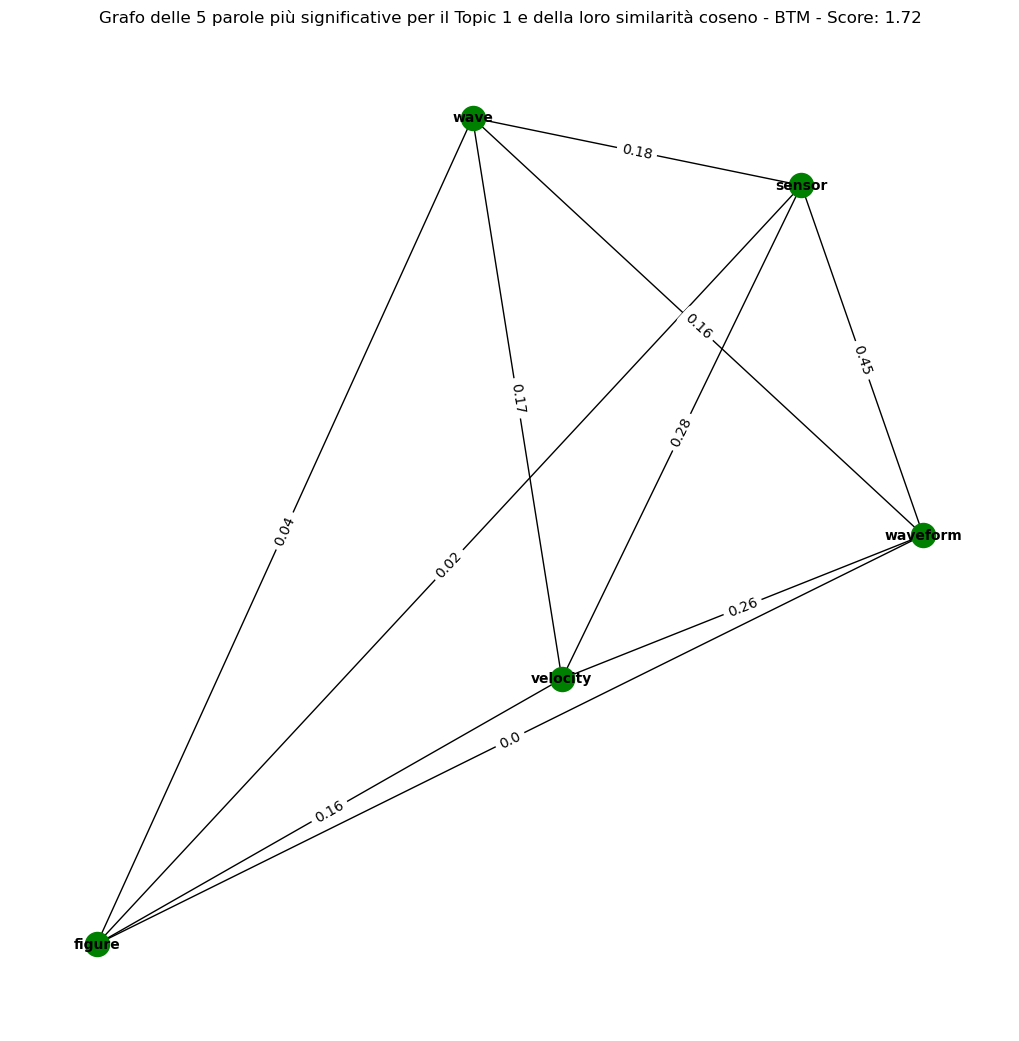

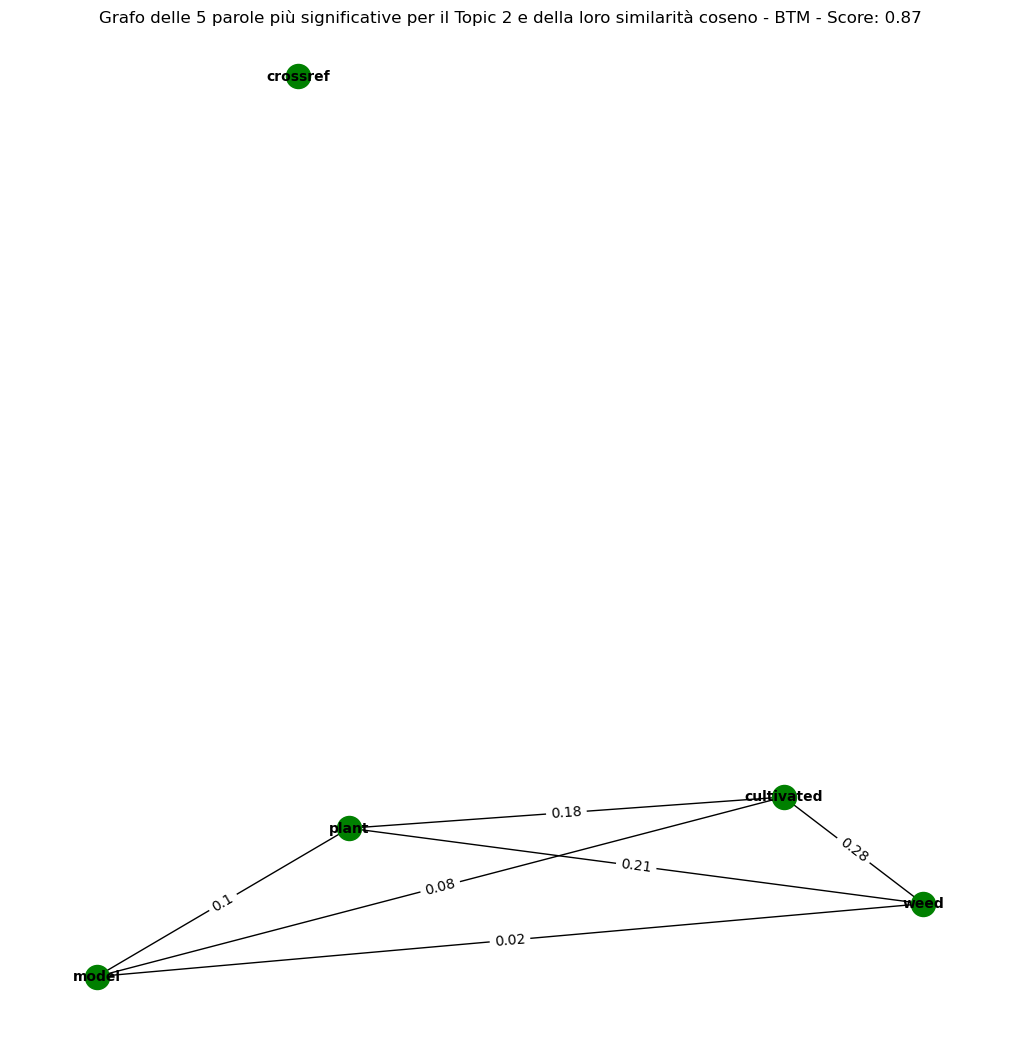

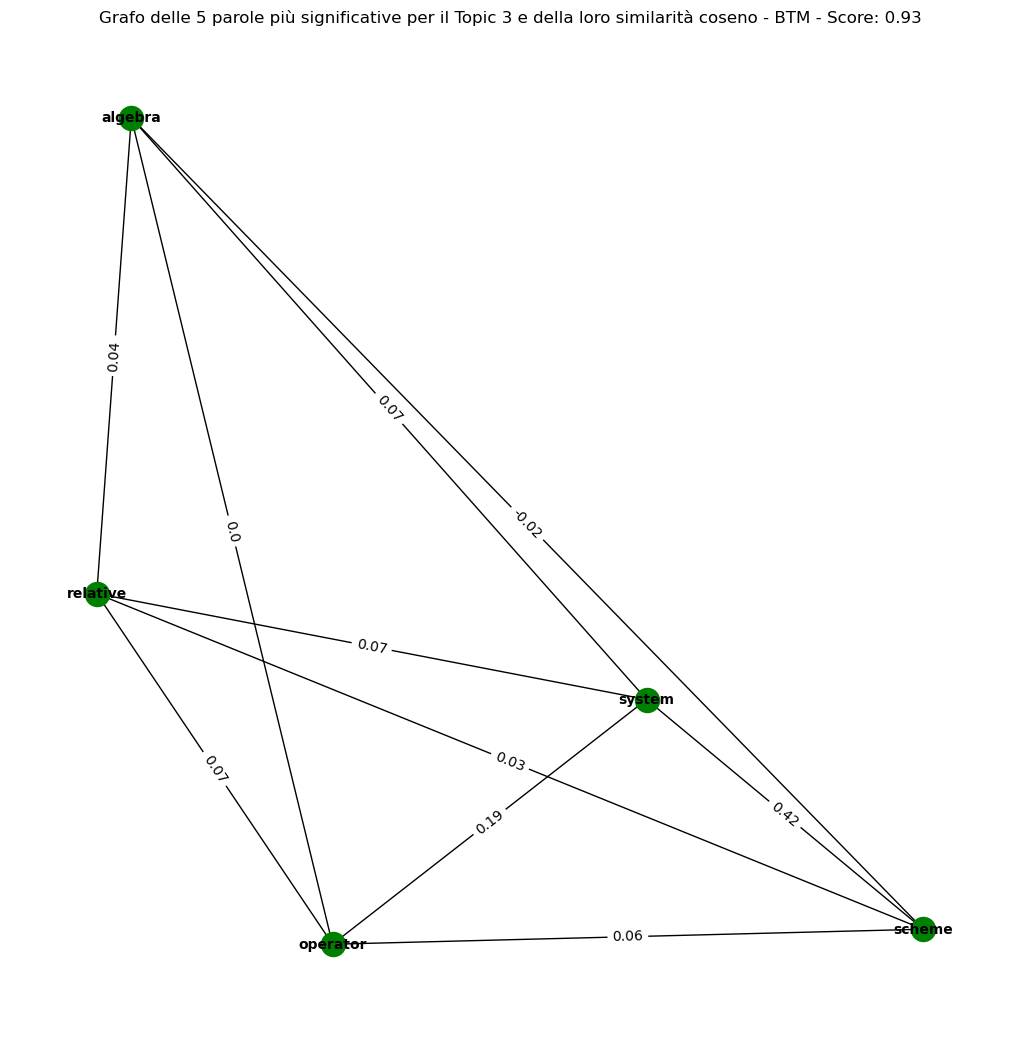

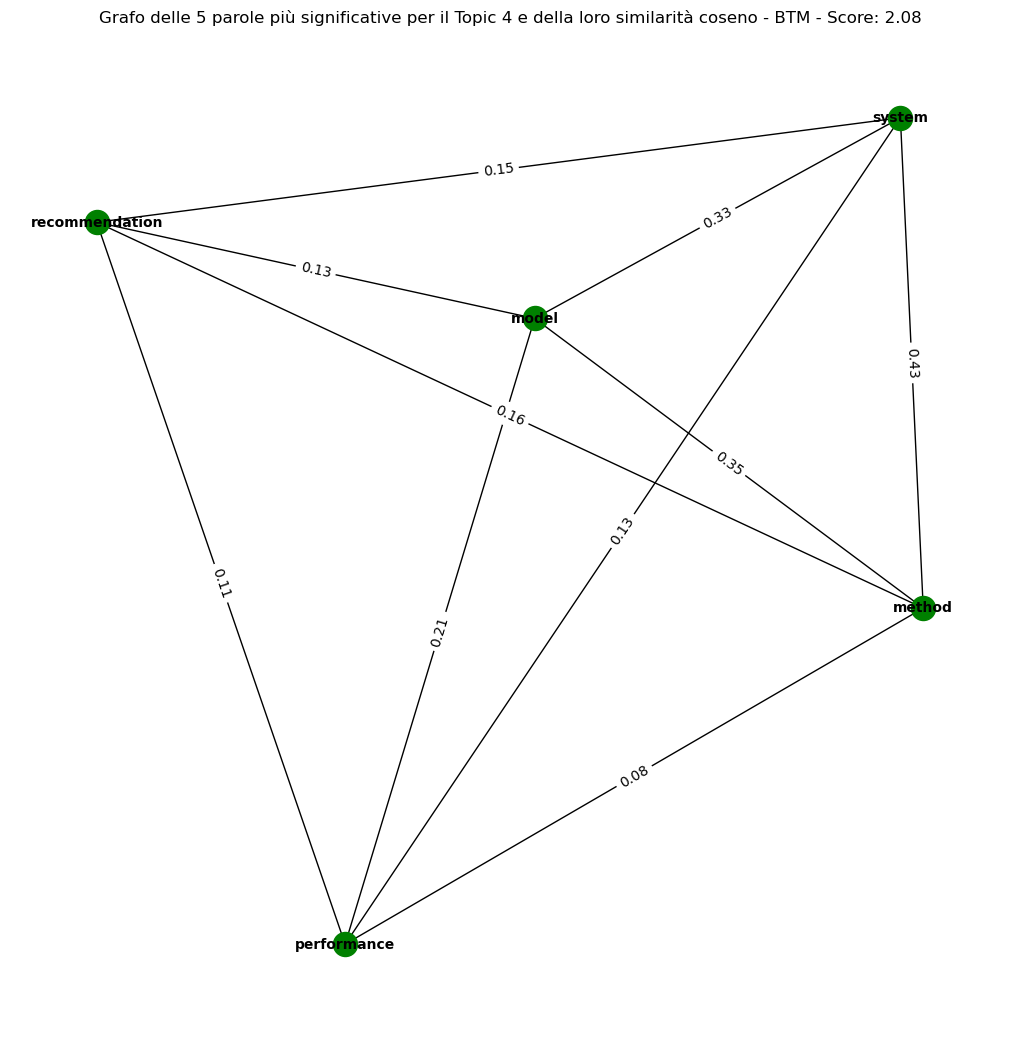

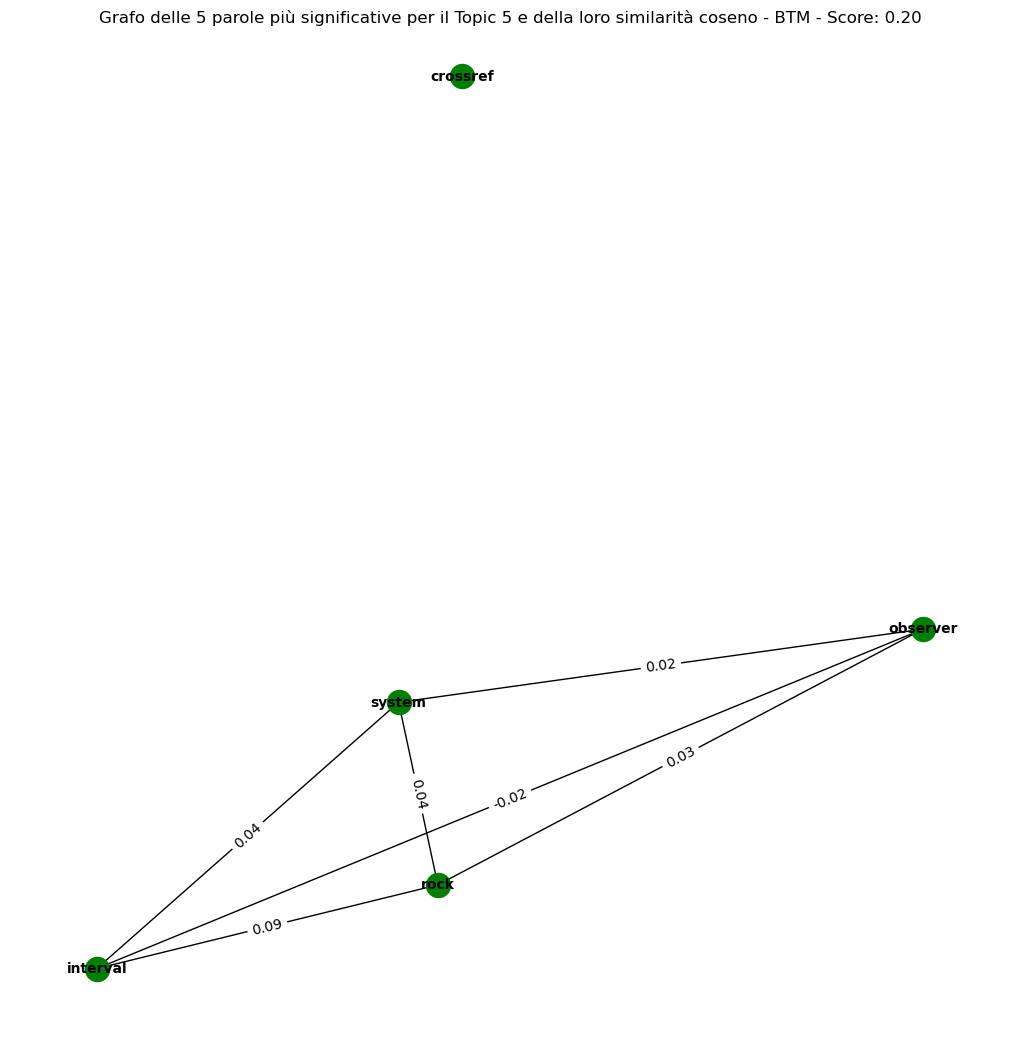

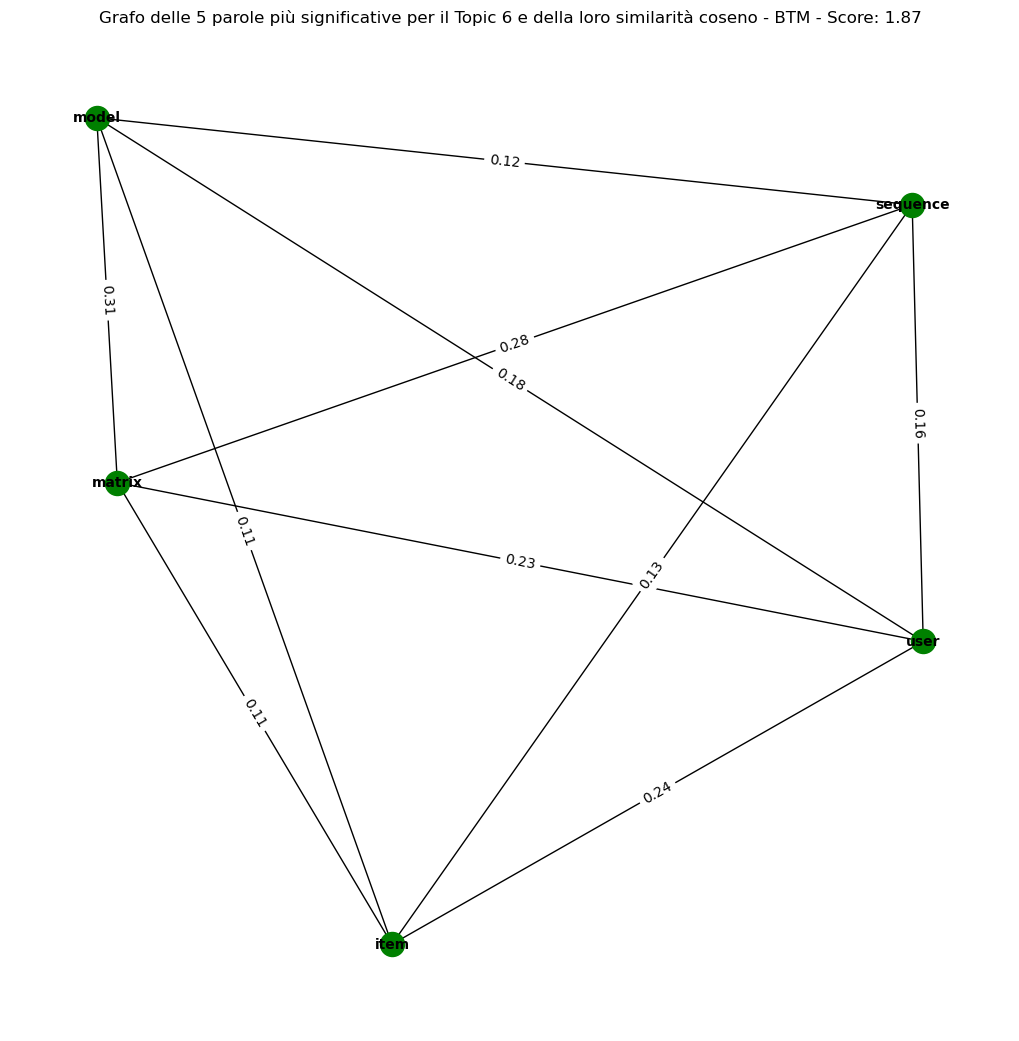

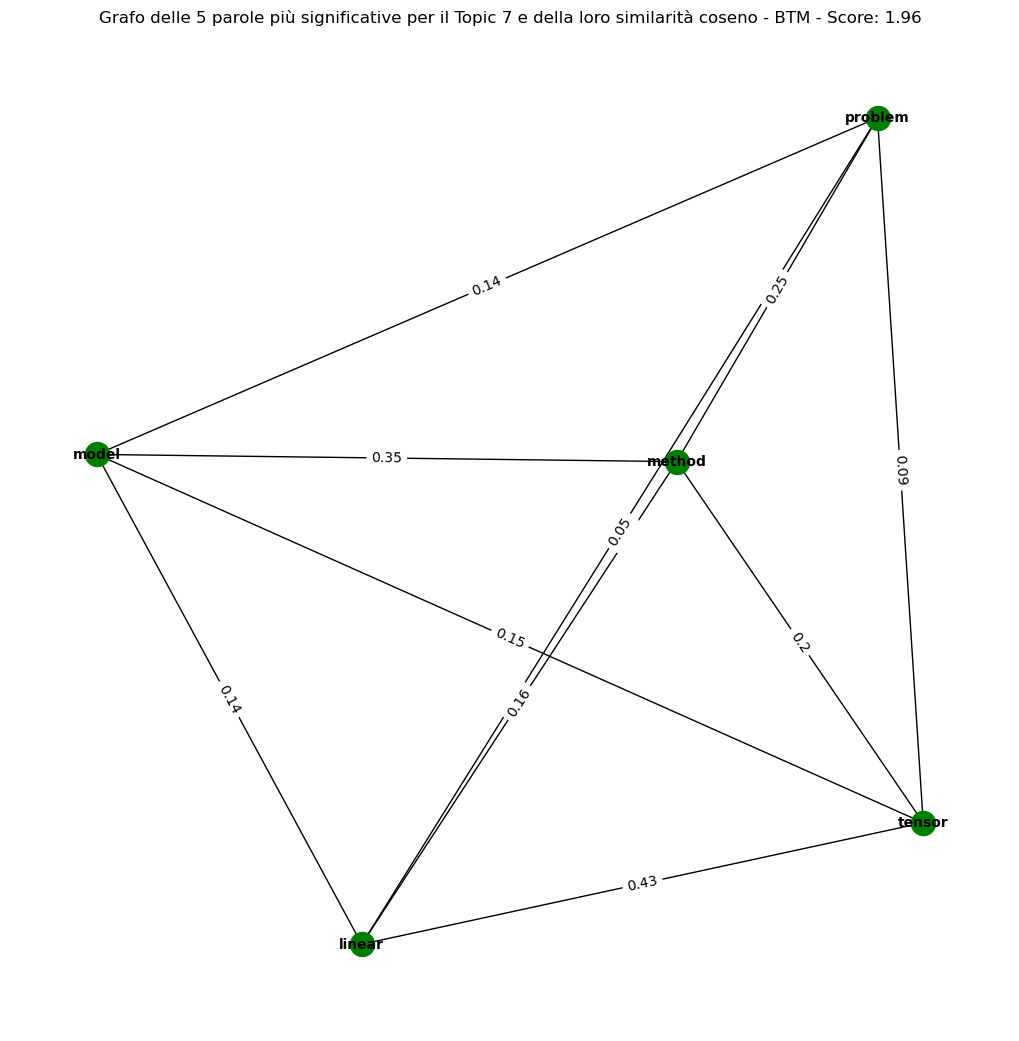

Topic 1: Score = 1.72
Topic 2: Score = 0.87
Topic 3: Score = 0.93
Topic 4: Score = 2.08
Topic 5: Score = 0.20
Topic 6: Score = 1.87
Topic 7: Score = 1.96
 Score Totale: 9.63


In [68]:
tabella = btm.get_top_topic_words(BTM_model, words_num=5)


word2vec_model = api.load("word2vec-google-news-300")

df = btm.get_top_topic_words(BTM_model, words_num=5)

num_words_per_topic = 5

graph_scores = []

for column in df.columns:
    topic_id = column
    topic_words = df[column].tolist()
    
    G_topic = nx.Graph()
    
    for word in topic_words[:num_words_per_topic]:
        G_topic.add_node(word)
    
    for i in range(len(topic_words)):
        for j in range(i+1, len(topic_words)):
            word1 = topic_words[i]
            word2 = topic_words[j]
            
            try:
                embedding_word1 = word2vec_model[word1]
                embedding_word2 = word2vec_model[word2]
            except KeyError:
        
                continue
            
            similarity = cosine_similarity([embedding_word1], [embedding_word2])[0][0]
            similarity_rounded = round(similarity, 2)
           
            G_topic.add_edge(word1, word2, weight=similarity_rounded)
    
   
    graph_score = sum(weight for _, _, weight in G_topic.edges(data='weight'))
    graph_scores.append((topic_id, graph_score))
    
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G_topic, seed=42)  # Posizioni dei nodi
    nx.draw(G_topic, pos, with_labels=True, node_size=300, node_color='green', font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(G_topic, 'weight')
    nx.draw_networkx_edge_labels(G_topic, pos, edge_labels=labels)
    numero_topic = topic_id.replace("topic", "")
    plt.title(f"Grafo delle 5 parole più significative per il Topic {int(numero_topic)+1} e della loro similarità coseno - BTM - Score: {graph_score:.2f}")
    plt.show()

score_totale = 0
    
for topic_id, score in graph_scores:
    print(f"Topic {int(topic_id.replace('topic', ''))+1}: Score = {score:.2f}")

    score_totale += score

print(f" Score Totale: {round(score_totale,2)}")


In [49]:
# TEXTRANK SUMMARIZATION


def estrai_testo(articolo):
    match = re.search(r'1\. Introduction(.*?)Conclusions', articolo, re.DOTALL)
    
    if match:
        testo_estratto = match.group(1).strip()  
        return testo_estratto
    else:
        match = re.search(r'1\. Introduction(.*?)References', articolo, re.DOTALL)
        if match:
            testo_estratto = match.group(1).strip() 
            return testo_estratto
        else:
            return "" 

def pulisci_testo(testo):
    
    testo_pulito_summary = re.sub(r'\b\d+\b', '', testo)  # Rimuovi numeri interi
    testo_pulito_summary = re.sub(r'\b\d+\.\d+\b', '', testo_pulito_summary)  # Rimuovi numeri decimali
    testo_pulito_summary = re.sub(r'[\(\[].*?[\)\]]', '', testo_pulito_summary)  # Rimuovi espressioni tra parentesi
    testo_pulito_summary = re.sub(r',,', ',', testo_pulito_summary)  
  
    return testo_pulito_summary


for i, doc in enumerate(corpus):
    
    
   
    testo = estrai_testo(testi_articoli[i])
    testo_pulito_summary = pulisci_testo(testo)
    parser = PlaintextParser.from_string(testo_pulito_summary, Tokenizer("english"))  
    summarizer = TextRankSummarizer()
    riassunto = summarizer(parser.document, 2)  
    
    
    print(f"\nRiassunto dell'articolo {i+1}:\n")
    for frase in riassunto:
        print(frase)
    
   
    topics = lda_model.get_document_topics(doc)
    print("\nNumero del topic asseganto a questo articolo da LDA:", (topics[0][0]+1), " con probabilità:", round(topics[0][1],4), "%\n")
    print('\n')

        


Riassunto dell'articolo 1:

This is because the training of the SIATR model mainly involves learning the feature space distribution of the samples, including the shape of the target, the brightness of the imaging, and the characteristics of the background region.
The calculation process of the weight matrix UP;  three candidate model examples and the acquisition method of the weights Uj,iand Pj,ifor a single sample with a certain label set to .Mathematics  ,   of • For the i-th input image, the mask image is obtained using the method in Figure , and the attribute partition interval of the image is obtained using the following formula: Ai=h Attribute 1ti, .

Numero del topic asseganto a questo articolo da LDA: 3  con probabilità: 0.9999 %




Riassunto dell'articolo 2:

So, for example, there was active discussion on the Internet about wing nut somersaults in zero gravity, which were observed by Janibekov, and which, nevertheless, are perfectly described by this model .Mathematics  ,  

In [51]:
# DOCUMENT CLUSTERING a partire da LDA

distribuzioni_topic = []
for doc_bow in corpus:
    distribuzione = lda_model[doc_bow]
    distribuzioni_topic.append([prob for _, prob in distribuzione])


num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(distribuzioni_topic)


for cluster in range(num_clusters):
    print(f"\nCluster {cluster + 1}:")
    for i, label in enumerate(kmeans.labels_):
        if label == cluster:
            print(f"- Documento {i + 1}")
            
silhouette_avg = silhouette_score(distribuzioni_topic, kmeans.labels_)
silhouette_avg = int(silhouette_avg * 100) / 100
print(f"\n\nSilhouette Score medio: {silhouette_avg}")


Cluster 1:
- Documento 6
- Documento 7

Cluster 2:
- Documento 1
- Documento 5
- Documento 8

Cluster 3:
- Documento 2
- Documento 3
- Documento 4
- Documento 9

Cluster 4:
- Documento 10


Silhouette Score medio: 0.66
